# Extract, Load, Transform

The idea is to get the data, to store it in a central location (instead of thousands of segment files) and to logically breakdown the data into segments for the train data in order to create our samples. 
1. get the data from Kaggle
2. centralize the data in 2 parquet files (train/test), we will also complement the data by adding the segment information (to acccess easily to a segment data) and a row number (to avoid loosing the sequence). 
3. for each segment, will will create some dense vectors with all observations for a segment to help the processing afterwards. We will use the RDD map and reduce functions for that.  

## 1 Get the data  

Recall from the previous step, download the data from Kaggle and extract it 

In [3]:
# ! pip install kaggle
# restart kernel
# ! /home/spark/shared/user-libs/python3/bin/kaggle
# ! echo "{\"username\":\"xxxxxxxxxx\",\"key\":\"xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx\"}" > /home/spark/shared/.kaggle/kaggle.json
# ! /home/spark/shared/user-libs/python3/bin/kaggle competitions download -c LANL-Earthquake-Prediction
# ! rm /home/spark/shared/.kaggle/kaggle.json
# ! mkdir kdata
# ! mv sample_submission.csv kdata/sample_submission.csv 
# ! mv test.zip kdata/test.zip
# ! mv train.csv.zip kdata/train.csv.zip
# ! unzip kdata/train.csv.zip -d kdata
# ! chmod 777 kdata/train.csv
# ! mkdir kdata/test
# ! unzip kdata/test.zip -d kdata/test  
# # 1% sample for tests : 
# ! rm kdata/train0.csv
# ! head -n6291455 kdata/train.csv > kdata/train0.csv
# ! rm -R kdata/train
# ! mkdir kdata/train
# ! sed '1d' kdata/train.csv > kdata/train_nh.csv
# ! split -l 150000 kdata/train_nh.csv kdata/train/Seg_ --numeric-suffixes=1 -a 5
# ! rm -R kdata/train_nh.csv

# ! ls kdata -ltra 

! echo "train.csv"
! echo "--------------------"
! head kdata/train.csv
! echo ""
! echo "test/seg_51f6fd.csv"
! echo "--------------------"
! head kdata/test/seg_51f6fd.csv 

# ! rm -R train.parquet*

# ! ls kdata/train
# ! rm -R temp_data_file
# ! ls

train.csv
--------------------
acoustic_data,time_to_failure
12,1.4690999832
6,1.4690999821
8,1.469099981
5,1.4690999799
8,1.4690999788
8,1.4690999777
9,1.4690999766
7,1.4690999755
-5,1.4690999744

test/seg_51f6fd.csv
--------------------
acoustic_data
6
5
-1
3
7
5
8
8
6


## 2 Load and format the data  

- Train : 1 csv to 1 parquet file
- Test : multiple csv to 1 parquet file  

In [4]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, DoubleType
from pyspark.sql.functions import monotonically_increasing_id, row_number, lit
from pyspark.sql.window import Window
import pyspark.sql.functions as fn
import os

In [5]:
schema = StructType([
    StructField("x", DoubleType(), True),
    StructField("y", DoubleType(), True)])

w1 = Window.orderBy("uid")
w2 = Window.partitionBy("seg").orderBy("uid")
df_train = spark.read.csv(os.path.join("kdata","train.csv"), header=True,schema=schema).withColumn(
    "uid", monotonically_increasing_id()).withColumn(
    "idx", row_number().over(w1).cast(IntegerType())).withColumn(
    "seg", fn.floor(((fn.col("idx")-1)/150000)).cast(IntegerType())).withColumn(
    "no", row_number().over(w2).cast(IntegerType())).withColumn(
    "name", fn.concat(lit("raw_"),fn.lpad(fn.col("seg"),4,"0").cast(StringType()))).withColumn(
    "set", lit(0))

df_train.createOrReplaceTempView("data")
df_train_f = spark.sql("""
SELECT uid, set, seg, no, name, x, y FROM data 
ORDER BY set, seg, no, uid
""")

df_train_f = df_train_f.repartition(1)
df_train_f.write.mode("overwrite").parquet(os.path.join("kdata", "train.parquet"))

In [6]:
df_train = spark.read.parquet(os.path.join("kdata", "train.parquet"))
df_train.createOrReplaceTempView("data")
max_id = spark.sql("""
SELECT max(uid) as m FROM data
""").first().m
print("max_id", max_id)

max_id 609887096053


In [8]:
# create groups of 20 well formatted
# doesn't like 2624 union, so we have to process by group : 2624 -> 132

import pandas as pd
df_result = pd.read_csv(os.path.join("kdata", "sample_submission.csv"))
files = list(df_result["seg_id"].values)

schema = StructType([StructField("x", DoubleType(), True)])

seg = 0
for file in files:
    sep = "."
    if seg % 200 == 0: sep = "|"    
    if seg % 20 == 0: print(sep, end="", flush=True)
    seg += 1
print("", end="\n", flush=True)

seg = 0
df_test = None
for file in files:
#     print(file)
    if seg % 20 == 0: print("|", end="", flush=True)

    w1 = Window.orderBy("uid")
    w2 = Window.partitionBy("seg").orderBy("uid")
    df_temp = spark.read.csv(os.path.join("kdata", "test", file+".csv"), header=True,schema=schema).withColumn(
        "y", lit(None).cast(DoubleType())).withColumn(
        "uid", lit(max_id+1)+monotonically_increasing_id()).withColumn(
        "idx", row_number().over(w1).cast(IntegerType())).withColumn(
        "seg", lit(seg).cast(IntegerType())).withColumn(
        "no", row_number().over(w2).cast(IntegerType())).withColumn(
        "name", (lit(file.split(".")[0])).cast(StringType())).withColumn(
        "set", lit(1))

    df_temp.createOrReplaceTempView("data")
    df_temp_f = spark.sql("""
    SELECT uid, set, seg, no, name, x, y FROM data
    ORDER BY set, seg, no, uid
    """)

    max_id = spark.sql("""
    SELECT max(uid) as m FROM data
    """).first().m

    seg += 1

    if df_test == None : df_test = df_temp_f
    else: df_test = df_test.union(df_temp_f)

    # create 1 file per 20 = I had issue when processing all in one go
    if seg % 20 == 0: 
        file_name = "test_1_{:04}.parquet".format(seg)
        df_test = df_test.repartition(1)
        df_test.write.parquet(os.path.join("kdata", file_name))
        df_test = None
#     if seg == 4 : break 

print("(", end="", flush=True)
# left under 20 batch
if df_test != None : 
    file_name = "test_1_{:04}.parquet".format(seg)
    df_test = df_test.repartition(1)
    df_test.write.parquet(os.path.join("kdata", file_name))
    df_test = None
print("x)", end="\n", flush=True)
    
print("max_id", max_id)

|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||(x)
max_id 610280696053


In [11]:
# process intermediary files  132 -> 1

import os

import pandas as pd
df_result = pd.read_csv(os.path.join("kdata", "sample_submission.csv"))
files = list(df_result["seg_id"].values)

seg = 0
for file in files:
    sep = "."
    if seg % 200 == 0: sep = "|"    
    if seg % 20 == 0: print(sep, end="", flush=True)
    seg += 1
print("", end="\n", flush=True)

seg = 0
mode = "overwrite"
for file in files:
    if seg % 20 == 0: print("|", end="", flush=True)
    seg += 1

    if seg % 20 == 0: 
        file_name = "test_1_{:04}.parquet".format(seg)
        df_test = spark.read.parquet(os.path.join("kdata", file_name))
        df_test.write.mode(mode).parquet(os.path.join("kdata", "test.parquet"))
        mode = "append"

print("(", end="", flush=True)

# left under 20 batch
if seg % 20 != 0 : 
    file_name = "test_1_{:04}.parquet".format(seg)
    df_test = spark.read.parquet(os.path.join("kdata", file_name))
    df_test.write.mode(mode).parquet(os.path.join("kdata", "test.parquet"))
    mode = "append"

print("x", end="", flush=True)

print(")", end="\n", flush=True)


|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||(x)


In [12]:
# check the data 

df_train = spark.read.parquet(os.path.join("kdata", "train.parquet"))
df_test = spark.read.parquet(os.path.join("kdata", "test.parquet"))

for df in [df_train, df_test]:
    df.createOrReplaceTempView("data")
    nb_seg = spark.sql("""
    SELECT set, seg, COUNT(*) AS n FROM data GROUP BY set, seg
    """)

    pddf = nb_seg.toDF("set", "seg", "n").toPandas()

    print("shape", pddf.shape)
    print("!= 150 000",pddf[pddf["n"]!=150000])

#30 sec to perform a calculation on the whole dataset, that sounds good

shape (4195, 3)
!= 150 000       set   seg      n
2248    0  4194  45480
shape (2624, 3)
!= 150 000 Empty DataFrame
Columns: [set, seg, n]
Index: []


In [14]:
# clean construction files
import shutil

seg = 0
for file in files:
    sep = "."
    if seg % 200 == 0: sep = "|"    
    if seg % 20 == 0: print(sep, end="", flush=True)
    seg += 1
print("", end="\n", flush=True)

seg = 0
for file in files:
    if seg % 20 == 0: print("|", end="", flush=True)
    seg += 1

    if seg % 20 == 0: 
        file_name = "test_1_{:04}.parquet".format(seg)
        shutil.rmtree(os.path.join("kdata", file_name))

print("(", end="", flush=True)
# left under 20 batch
if seg % 20 != 0 : 
    file_name = "test_1_{:04}.parquet".format(seg)
    shutil.rmtree(os.path.join("kdata", file_name))
print("x", end="", flush=True)
print(")", end="\n", flush=True)




|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|.
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||(x)


## 3 Dense Vectors Creation   

For each segment, we will create 10 sequential windows of data that we will wrap into a dense vector. It will help us to process the data in the next step. 
Why 10 windows ? Because creating a vector of size 150,000 makes the Spark driver throw a memory exception, so we breakdown the work into 10 smaller tasks.
Also, those 10 windows may be usefull to analyze the data sequence by sequence 


We will use the RDD map and reduce functions to create a large dense vector feature per time window

In [15]:
# train data
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row

df = spark.read.parquet(os.path.join("kdata", "train.parquet"))
df.createOrReplaceTempView("data")


df_agg = sc.parallelize([])
for i in range(10):
    sql = """
    SELECT seg, x FROM data WHERE set = 0 AND no BETWEEN {0} AND {1} ORDER BY uid
    """.format(i*15000, (i+1)*15000)
    df_temp = spark.sql(sql)
    rdd_temp = df_temp.rdd.map(lambda row:(row.seg,row.x))      \
        .map(lambda data: (data[0], [ data[1] ]))               \
        .reduceByKey(lambda a, b: a + b)                        \
        .map(lambda row: Row(seg=row[0],vx=Vectors.dense(row[1])))      
    if df_agg.count() == 0: 
        df_agg = rdd_temp.toDF(["seg","vx"+str(i)])
    else: 
        df_temp = rdd_temp.toDF(["seg0","vx"+str(i)])
        df_agg = df_agg.join(df_temp, df_agg.seg == df_temp.seg0).drop("seg0")

df_agg.write.mode("overwrite").parquet(os.path.join("kdata", "train.vector.parquet"))

In [16]:
# test data
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row

df = spark.read.parquet(os.path.join("kdata", "test.parquet"))
df.createOrReplaceTempView("data")


df_agg = sc.parallelize([])
for i in range(10):
    sql = """
    SELECT seg, x FROM data WHERE set = 1 AND no BETWEEN {0} AND {1} ORDER BY uid
    """.format(i*15000, (i+1)*15000)
    df_temp = spark.sql(sql)
    rdd_temp = df_temp.rdd.map(lambda row:(row.seg,row.x))      \
        .map(lambda data: (data[0], [ data[1] ]))               \
        .reduceByKey(lambda a, b: a + b)                        \
        .map(lambda row: Row(seg=row[0],vx=Vectors.dense(row[1])))      
    if df_agg.count() == 0: 
        df_agg = rdd_temp.toDF(["seg","vx"+str(i)])
    else: 
        df_temp = rdd_temp.toDF(["seg0","vx"+str(i)])
        df_agg = df_agg.join(df_temp, df_agg.seg == df_temp.seg0).drop("seg0")

df_agg.write.mode("overwrite").parquet(os.path.join("kdata", "test.vector.parquet"))

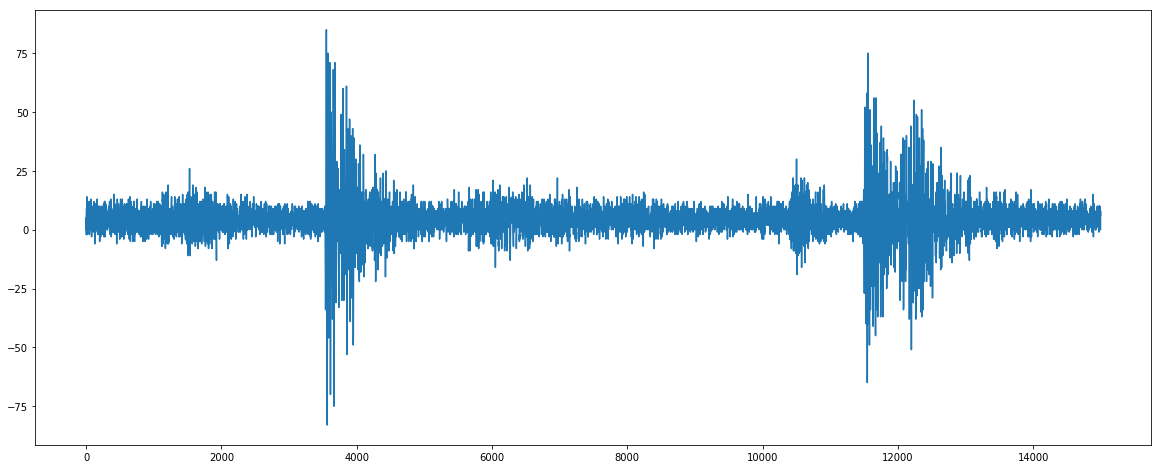

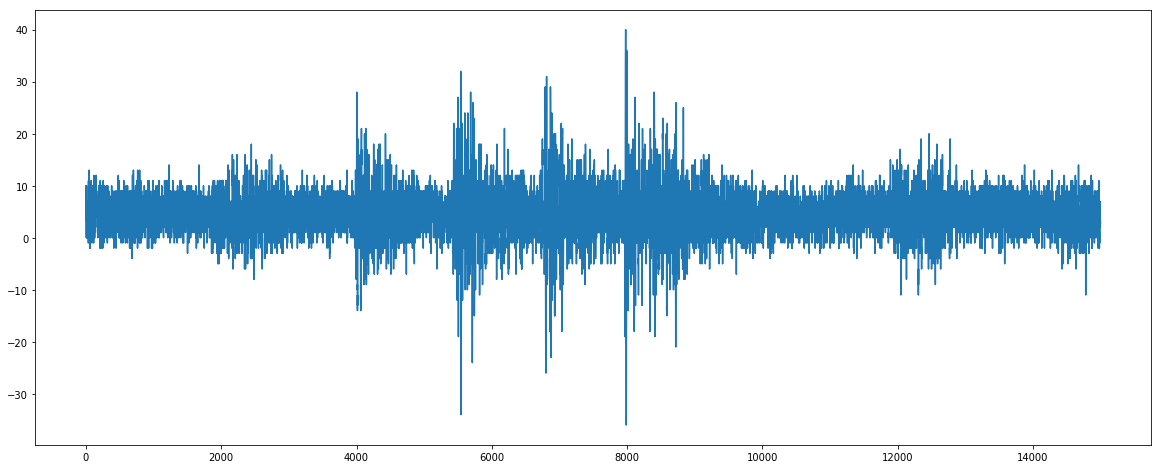

In [26]:
#check data 

import matplotlib.pyplot as plt 
%matplotlib inline

df_vect = spark.read.parquet(os.path.join("kdata", "train.vector.parquet"))

fig = plt.figure(figsize=(20,8))
pdf_vect = df_vect.selectExpr("vx7").where("seg=1236").toPandas()
y = pdf_vect["vx7"].values.reshape(-1,1)[0][0].toArray()
plt.plot(y[2:])


df_vect = spark.read.parquet(os.path.join("kdata", "test.vector.parquet"))

fig = plt.figure(figsize=(20,8))
pdf_vect = df_vect.selectExpr("vx4").where("seg=1436").toPandas()
y = pdf_vect["vx4"].values.reshape(-1,1)[0][0].toArray()
plt.plot(y[2:])

# y.shape

In [28]:
print("-- train schema -- ")
df = spark.read.parquet(os.path.join("kdata", "train.parquet"))
df.printSchema()

print("-- train vector schema -- ")
df = spark.read.parquet(os.path.join("kdata", "train.vector.parquet"))
df.printSchema()

print("-- test schema -- ")
df = spark.read.parquet(os.path.join("kdata", "test.parquet"))
df.printSchema()

print("-- test vector schema -- ")
df = spark.read.parquet(os.path.join("kdata", "test.vector.parquet"))
df.printSchema()

-- train schema -- 
root
 |-- uid: long (nullable = true)
 |-- set: integer (nullable = true)
 |-- seg: integer (nullable = true)
 |-- no: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)

-- train vector schema -- 
root
 |-- seg: long (nullable = true)
 |-- vx0: vector (nullable = true)
 |-- vx1: vector (nullable = true)
 |-- vx2: vector (nullable = true)
 |-- vx3: vector (nullable = true)
 |-- vx4: vector (nullable = true)
 |-- vx5: vector (nullable = true)
 |-- vx6: vector (nullable = true)
 |-- vx7: vector (nullable = true)
 |-- vx8: vector (nullable = true)
 |-- vx9: vector (nullable = true)

-- test schema -- 
root
 |-- uid: long (nullable = true)
 |-- set: integer (nullable = true)
 |-- seg: integer (nullable = true)
 |-- no: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)

-- test vector schema -- 
root
 |-- seg: long (nu